# TENSORFLOW - LSTM

Dans cette partie sur tensorflow, nous allons essayer d'améliorer les prédictions des modèles scikit learn en utilisant le modèle Long Short Term Memory ($LSTM$).

Le $LSTM$ est une variante des réseaux de neuronnes récurrent ($RNN$), c'est à dire que les neurones utilisent leur sortie comme un nouvel input.
Ce type de modèle est généralement exposé à l'explosion ou la disparition du gradient à cause de leur aspect récursif.

Cependant, le $LSTM$ permet de régler ce problème en instaurant une cellule d'état. Cette cellule comporte 3 portes : porte d'oublie (% de la mémoire long terme oubliée), la porte d'entrée (création d'une mémoire long terme) et porte de sortie (création de mémoire court terme). A chaque observation, le neurone met à jour l'état de la cellule afin de récupérer l'effet long terme (tendance par exemple) et l'effet court terme (de volatilité dans notre cas).

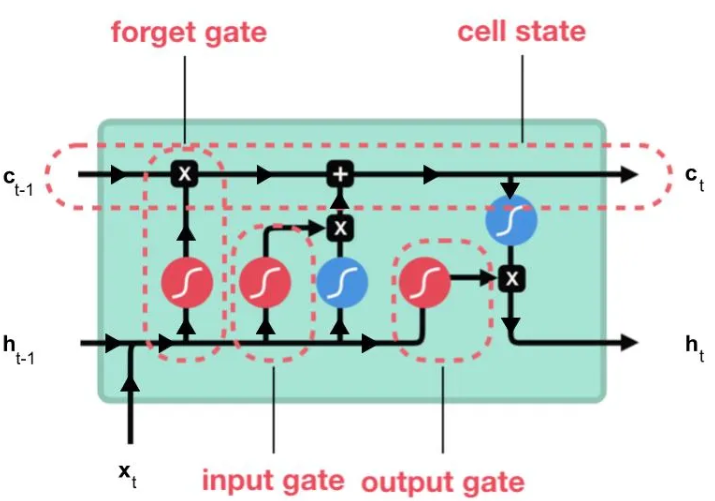

Le $LSTM$ est donc particulièrement utilisé pour effectuer des prédictions de séries temporelles et c'est ce pourquoi nous allons l'utiliser pour tenter d'améliorer les performances de nos modèles par rapport à la problématique. Pour rappel, nous devons prédire si le prix de clôture au terme du jour $N_{+1}$ va augmenter ou diminuer par rapport au jour $N$.

Pour ce faire, nous allons d'abord prédire le prix du lendemain grâce au $LSTM$, puis nous crérons des variables cibles pour mesurer la précision du modèle.
Les variables évaluent si le cours a monté sur les données réelles et sur les prédictions. Nous pourrons comparer ces variables avec des métriques de classification.

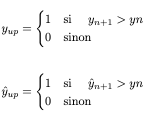

Nous allons d'abord utiliser seulement l'évolution de la variable Close_price, le prix de fermeture de chaque bougies.
Nous utiliserons ensuite les autres variables permettant de créer les datasets v2 pour tenter d'améliorer le modèle.


***


## <font color='white'>PRÉSENTATION DU MODÈLE</font>

Le réseau de neuronnes LSTM est composé de plusieurs couches. Une première couche d'input pour spécifier la forme de notre jeu de données en entrée. En effet, ce réseau de neuronnes demande une mise en forme particulière :  Le jeu d'entrée est de dimension trois, nous y reviendrons. Pour cette raison nous devons en préciser 2, à savoir la taille de la fenêtre (window_size) et le nombre de variable (n_features), la troisième étant le nombre d'observations.

Nous enchaînons avec une couche de 256 neuronnes LSTM effectuant le traitement que nous avons évoqué précédemment. Une couche Dense de 64 neuronnes est aussi ajouté afin d'utiliser l'apprentissage d'un réseau de neuronnes classique.
Les couches de Dropout permettent d'oublier un pourcentage des neuronnes de la couche précédente dans le but d'éviter l'overfitting. Nous supprimons donc 50% des neuronnes apres LSTM et 20% apres la couche dense.

L'architecture de ce modèle est inspiré de celle du papier de M. Patrick Jaquart:
https://www.sciencedirect.com/science/article/pii/S2405918821000027

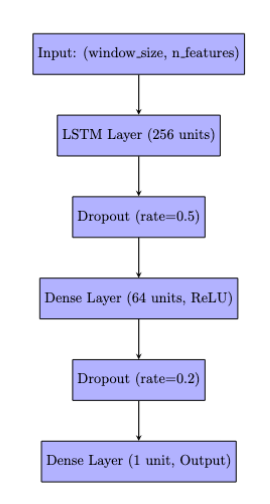

***
## Critique par l'IA

Questions :

D'abord décris, le modèle et ses particularités. présente le ensuite sous forme de graphe Latex. Pense tu que le modèle sera performant, si oui pourquoi, si non pourquoi. Si le modèle présenté ci dessus te semble peu efficace pour notre problématique, propose en un autre.

Réponse de l'IA :

Le modèle présenté est un réseau neuronal récurrent basé sur une architecture LSTM (Long Short-Term Memory), combinée avec des couches entièrement connectées (Dense). Voici ses composants et particularités :


<font color='cyan'>Entrée (Input Layer):</font>

- Dimension des entrées : (window_size, n_features).
- Reçoit des séquences temporelles contenant window_size pas de temps et n_features caractéristiques pour chaque pas de temps.

<font color='cyan'>LSTM Layer:</font>

- 256 unités dans la couche LSTM.
- Les LSTM sont efficaces pour capturer les dépendances temporelles et les patterns dans les données séquentielles comme les séries temporelles.


<font color='cyan'> Dropout Layers: </font>

- Dropout(0.5) après la couche LSTM.
- Dropout(0.2) après la première couche Dense.
- Les couches de dropout servent à prévenir le surapprentissage en désactivant aléatoirement une proportion donnée de neurones pendant l'entraînement.


<font color='cyan'>Dense Layers:</font>

- Une couche Dense avec 64 unités et une activation ReLU.
- Une couche Dense finale avec une unité sans activation explicite, produisant une prédiction scalaire (le prix attendu).


<font color='cyan'>Sortie (Output Layer):</font>

- Prédit une valeur continue (le prix ou le changement de prix).

#### Analyse des Performances du Modèle

<font color='cyan'>Points Positifs :</font>

&nbsp;&nbsp;&nbsp;&nbsp;Utilisation des LSTM :

- Les LSTM sont bien adaptés aux séries temporelles, car ils peuvent capturer des dépendances à long terme et à court terme dans les données.
Ils peuvent gérer des dynamiques complexes des marchés financiers, comme les patterns temporels.

&nbsp;&nbsp;&nbsp;&nbsp;Dropout :

- Réduit le surapprentissage, ce qui est crucial pour les séries temporelles avec des données limitées ou bruitées.

&nbsp;&nbsp;&nbsp;&nbsp;Dense Layers :

- Permet au modèle de transformer les représentations apprises par la LSTM en une sortie prédictive.

<font color='cyan'>Limites :</font>

&nbsp;&nbsp;&nbsp;&nbsp;Capacité limitée à gérer des mouvements erratiques :

- Les LSTM peuvent être limités lorsqu'il s'agit de prédire des événements rares ou erratiques.
Ces événements nécessitent souvent une modélisation probabiliste explicite, absente ici.

&nbsp;&nbsp;&nbsp;&nbsp;Taille Fixe de la Fenêtre Temporelle :

- L'utilisation d'une fenêtre glissante de taille fixe (window_size) peut ne pas capturer toutes les dépendances temporelles.

&nbsp;&nbsp;&nbsp;&nbsp;Absence de gestion des incertitudes :

- Le modèle ne génère pas d'intervalles de confiance, ce qui est essentiel pour évaluer la fiabilité des prédictions dans un environnement volatile.

<font color='cyan'>Proposition d'Amélioration</font>

Pour une meilleure performance sur des séries temporelles boursières erratiques, je propose une modification :

1. Attention Mechanism :
Ajoutez une couche d'attention après la LSTM pour permettre au modèle de se concentrer sur des étapes temporelles spécifiques plus importantes.

2. Bayesian Neural Network (BNN) :
Remplacez les couches denses classiques par des couches bayésiennes pour générer des prédictions probabilistes avec une estimation d'incertitude.

3. Incorporation de Facteurs Exogènes :
Intégrez des variables exogènes comme les volumes, sentiments ou événements majeurs pour enrichir le contexte.
***

### Présentation des fonctions de preprocessing, training et analyse

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, mean_absolute_percentage_error
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

load_dotenv()

WD = os.getenv('working_directory')

2025-01-17 07:42:10.586050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 07:42:10.791467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-17 07:42:10.791501: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-17 07:42:10.838237: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 07:42:11.758323: W tensorflow/stream_executor/pla

#### Pre processing

La partie de pre processing nous permet de transformer notre dataset brut en des matrices numpy à trois dimensions pour $X$ et deux pour $y$ tout en  appliquant quelques transformation.

Ce sont ces objets qui seront interpretés dans le modèle LSTM de tensorflow.

Description des fonctions main:

Nous chargeons le dataset, puis nous extrayons les variables `close_price` ou `log_close_price` ainsi que la `date`. Nous construisons ensuite la matrice en trois dimensions en récupérant l'évolution du prix sur la période de la taille de `window_size`. Dans notre cas, `window_size` vaut 7, donc nous aggregeons une semaine de données sur chaque ligne en glissant d'un jour à chaque nouvelle observation. Ce traitement est aussi adapté pour l'utilisation de plus d'une variable. 

Ensuite, nous séparons notre jeu de données en jeux de train, validation et test grâce à la valeur de la variable `train_size` et nous leur appliquons CHACUN leur propre normalisation. De ce fait, les moyennes et écart-types de chacun des datasets ne seront pas confondues, évitant ainsi le data leakage.

Les objets sortant de ce pré processing sont retournés dans un dictionnaire afin de facilement leur accès dans la suite du traitement.


In [2]:
######### Fonctions de preprocessing communes au modèle pour une ou plusieurs variables #########

def load_data(name):
    """
    Charge un dataframe depuis un fichier CSV situé dans le répertoire data.

    Args:
        name (str): Nom du fichier CSV (sans extension).

    Returns:
        pandas.DataFrame: Le dataframe chargé depuis le fichier.
    """
    return pd.read_csv(f'{WD}/data/{name}.csv')

def get_close_price(df):
    """
    Extrait le prix de clôture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Close_price'.

    Returns:
        pandas.Series: Série contenant les prix de clôture.
    """
    return df['Close_price'].copy()

def get_log_close_price(df):
    """
    Extrait le logarithme naturel du prix de clôture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Close_price'.

    Returns:
        pandas.Series: Série contenant le logarithme naturel des prix de clôture.
    """
    return np.log(df['Close_price'].copy())

def get_date(df):
    """
    Extrait les dates d'ouverture depuis un dataframe.

    Args:
        df (pandas.DataFrame): Dataframe contenant une colonne 'Open_time'.

    Returns:
        pandas.Series: Série contenant les dates d'ouverture.
    """
    return df['Open_time'].copy()

def df_to_numpy(df):
    """
    Convertit un dataframe en matrice NumPy.

    Args:
        df (pandas.DataFrame): Dataframe à convertir.

    Returns:
        numpy.ndarray: Matrice NumPy contenant les données du dataframe.
    """
    return df.to_numpy()

def train_test_val(X, y, date, train_size):
    """
    Sépare les données en ensembles d'entraînement, de validation et de test.

    Args:
        X (numpy.ndarray): Caractéristiques (features).
        y (numpy.ndarray): Prix cibles
        date (pandas.Series): Dates
        train_size (float): Proportion des données utilisées pour l'entraînement (entre 0 et 1).

    Returns:
        tuple: Contient les ensembles séparés :
            - date_train, X_train, y_train (entraînement),
            - date_val, X_val, y_val (validation),
            - date_test, X_test, y_test (test).
    """
    q_train_size = int(len(X) * train_size)
    q_val_test_size = int(len(X) * (train_size + (1 - train_size) / 2))
    date_numpy = df_to_numpy(date)

    X_train, y_train, date_train = X[:q_train_size], y[:q_train_size], date_numpy[:q_train_size]
    X_val, y_val, date_val = X[q_train_size:q_val_test_size], y[q_train_size:q_val_test_size], date_numpy[q_train_size:q_val_test_size]
    X_test, y_test, date_test = X[q_val_test_size:], y[q_val_test_size:], date_numpy[q_val_test_size:]

    return date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test

def normalization(X, y):
    """
    Normalise les données à l'aide de MinMaxScaler.

    Args:
        X (numpy.ndarray): Données d'entrée multi-dimensionnelles.
        y (numpy.ndarray): Données de sortie (labels).

    Returns:
        tuple: Contient les données normalisées et le scaler utilisé :
            - X_train_scaled (numpy.ndarray): Données normalisées pour X.
            - y_train_scaled (numpy.ndarray): Données normalisées pour y.
            - scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour la normalisation.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y_train_scaled = scaler.fit_transform(y.reshape(-1, 1))

    return X_train_scaled, y_train_scaled, scaler

######################## Fonctions propres à une variable ########################

def window_matrix_one_var(df, window_size):
    """
    Construit une matrice pour une variable unique en utilisant une fenêtre glissante.

    Args:
        df (pandas.DataFrame): Dataframe contenant la variable à traiter.
        window_size (int): Taille de la fenêtre glissante.

    Returns:
        tuple: Contient les matrices X et y :
            - X (numpy.ndarray): Matrice contenant les fenêtres (a, b, c) où :
                a = # observations,
                b = window_size,
                c = 1 (variable unique).
            - y (numpy.ndarray): Labels associés (valeur suivante après chaque fenêtre).
    """
    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i:i + window_size]]
        X.append(row)
        y.append(df_numpy[i + window_size])

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

######################## Fonctions propres à plusieurs variables ########################

def formatting_data(df):
    """
    Prépare les données pour le preprocessing en mettant les colonnes au bon format pour les datasets_v2*

    Args:
        df (pandas.DataFrame): Dataframe brut contenant les données.

    Returns:
        tuple: Contient les données formatées :
            - date (pandas.Series): Série contenant les dates extraites.
            - df (pandas.DataFrame): Dataframe avec les colonnes formatées.
    """
    df.dropna(inplace=True)
    df['log_close_price'] = pd.Series(get_log_close_price(df))
    df.rename(columns={'date_utc': 'Open_time'}, inplace=True)
    date = get_date(df)
    df.drop('Open_time', axis=1, inplace=True)
    df.drop('Close_price', axis=1, inplace=True)

    # Positionne Close_price en premier pour faciliter l'identification dans la matrice (a,b,c)
    columns = ['log_close_price'] + [col for col in df.columns if col != 'log_close_price']
    df = df[columns]

    return date, df

def window_matrix_multi_var(df, window_size):
    """
    Construit une matrice pour plusieurs variables en utilisant une fenêtre glissante.

    Args:
        df (pandas.DataFrame): Dataframe contenant plusieurs variables.
        window_size (int): Taille de la fenêtre glissante.

    Returns:
        tuple: Contient les matrices X et y :
            - X (numpy.ndarray): Matrice contenant les fenêtres (a, b, c) où :
                a = # observations,
                b = window_size,
                c = # variables.
            - y (numpy.ndarray): Labels associés (valeurs de la première colonne après chaque fenêtre).
    """
    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    X = []
    y = []
    for i in range(len(df_numpy) - window_size):
        row = [a for a in df_numpy[i:i + window_size]]
        X.append(row)
        y.append(df_numpy[i + window_size][0])  # Récupère la première colonne

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)


In [3]:
######### Fonctions main #########

def main_pre_processing_close_price(name, window_size):
    """
    Prétraitement des données pour une seule variable : le prix de clôture.

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date = get_date(df)
    df_close_price = get_close_price(df)
    X, y = window_matrix_one_var(df_close_price, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets

def main_pre_processing_log_close_price(name, window_size):
    """
    Prétraitement des données pour une seule variable : le prix de clôture (logarithmique).

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date = get_date(df)
    df_log_close_price = get_log_close_price(df)
    X, y = window_matrix_one_var(df_log_close_price, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets

def main_pre_processing_multivar(name, window_size):
    """
    Prétraitement des données pour plusieurs variables 
    dont le log_close_price à la place du close_price

    Args:
        name (str): Nom du fichier CSV contenant les données (sans extension).
        window_size (int): Taille de la fenêtre temporelle utilisée pour créer les séquences.

    Returns:
        dict: Contient les datasets prétraités pour l'entraînement, la validation et le test.
              Chaque clé ('TRAIN', 'TEST', 'VAL') mappe une liste [date, X_norm, y_norm, scaler].
    """
    df = load_data(name)
    date, formated_df = formatting_data(df)
    print(formated_df.columns)
    X, y = window_matrix_multi_var(formated_df, window_size)
    date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test = train_test_val(X, y, date, 0.8)

    print("X.shape", X.shape)
    print("y.shape", y.shape)

    datasets = {}

    # TRAIN
    X_train_norm, y_train_norm, scaler_train = normalization(X_train, y_train)
    datasets['TRAIN'] = [[date_train, X_train_norm, y_train_norm, scaler_train]]
    print("X_train_norm.shape", X_train_norm.shape)
    print("y_train_norm.shape", y_train_norm.shape)

    # TEST
    X_test_norm, y_test_norm, scaler_test = normalization(X_test, y_test)
    datasets['TEST'] = [[date_test, X_test_norm, y_test_norm, scaler_test]]

    # VAL
    X_val_norm, y_val_norm, scaler_val = normalization(X_val, y_val)
    datasets['VAL'] = [[date_val, X_val_norm, y_val_norm, scaler_val]]

    return datasets


#### Training

La partie d'entrainement est relativement courte, c'est pourtant celle qui prend le plus de temps d'éxecution.
Nous construisons d'abord le modèle dont nous avons parlé, nous le compilons, puis nous l'entraînons grâce aux datasets train et validation.
Nous enregistrons le modèle grâce au checkpoint.

In [2]:
######### Fonctions de training communes au modèle pour une ou plusieurs variables #########

def prepare_model(name, n_features, window_size):
    """
    Construit la structure du modèle de réseau de neurones séquentiel avec des couches LSTM et Dense.

    Args:
        name (str): Nom du modèle.
        n_features (int): Nombre de caractéristiques (features) en entrée.
        window_size (int): Taille de la fenêtre temporelle (nombre de pas de temps).

    Returns:
        keras.Model: Modèle séquentiel construit avec les spécifications fournies.
    """
    model = Sequential(
        [
            Input((window_size, n_features)),
            LSTM(256),
            Dropout(0.5),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ], 
        name=name
    )
    return model

def prepare_checkpoint(name):
    """
    Prépare un callback pour sauvegarder le modèle au cours de l'entraînement.

    Args:
        name (str): Nom du modèle, utilisé pour définir le chemin de sauvegarde.

    Returns:
        keras.callbacks.ModelCheckpoint: Callback de sauvegarde configuré pour conserver 
        uniquement la meilleure version du modèle selon la métrique 'loss'.
    """
    return ModelCheckpoint(
        f'{WD}/src/model/models/{name}/', 
        save_best_only=True, 
        save_format='tf', 
        monitor='loss'
    )

def compile(model, learning_rate):
    """
    Configure le modèle pour l'entraînement en spécifiant la fonction de perte, l'optimiseur, et les métriques.

    Args:
        model (keras.Model): Modèle à compiler.
        learning_rate (float): Taux d'apprentissage pour l'optimiseur Adam.

    Returns:
        keras.Model: Modèle compilé prêt pour l'entraînement.
    """
    model.compile(
        loss=MeanSquaredError(), 
        optimizer=Adam(learning_rate=learning_rate), 
        metrics=[RootMeanSquaredError()]
    )
    return model

def fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS):
    """
    Entraîne le modèle en utilisant les ensembles d'entraînement et de validation.

    Args:
        model (keras.Model): Modèle à entraîner.
        cp (keras.callbacks.ModelCheckpoint): Callback pour sauvegarder le modèle pendant l'entraînement.
        X_train (numpy.ndarray): Données d'entrée pour l'entraînement.
        y_train (numpy.ndarray): Labels pour l'entraînement.
        X_val (numpy.ndarray): Données d'entrée pour la validation.
        y_val (numpy.ndarray): Labels pour la validation.
        N_EPOCHS (int): Nombre d'époques d'entraînement.

    Returns:
        keras.Model: Modèle entraîné.
    """
    model.fit(
        X_train, 
        y_train, 
        validation_data=(X_val, y_val), 
        epochs=N_EPOCHS, 
        callbacks=[cp]
    )
    return model

def main_training_model(model_name, X_train, y_train, X_val, y_val, window_size, N_EPOCHS):
    """
    Fonction principale pour entraîner un modèle.

    Args:
        model_name (str): Nom du modèle pour sauvegarde et identification.
        X_train (numpy.ndarray): Données d'entrée pour l'entraînement, de forme (échantillons, fenêtres, variables).
        y_train (numpy.ndarray): Cibles correspondantes pour l'entraînement.
        X_val (numpy.ndarray): Données d'entrée pour la validation.
        y_val (numpy.ndarray): Cibles correspondantes pour la validation.
        window_size (int): Taille de la fenêtre temporelle utilisée comme entrée du modèle.
        N_EPOCHS (int): Nombre d'époques d'entraînement.

    Returns:
        keras.Model: Modèle entraîné.
    """
    # Préparation du checkpoint pour sauvegarder le modèle
    cp = prepare_checkpoint(name=model_name)
    
    # Construction du modèle
    model = prepare_model(name=model_name, n_features=X_train.shape[2], window_size=window_size)
    
    # Compilation du modèle
    model = compile(model, 0.001)
    
    # Entraînement du modèle
    model = fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS)
    
    return model



#### Analyse

Dans la partie analyse, nous calculons les prédictions pour chaque dataset. Nous appliquons les normalisations inverses et remettons le prix en normal s'il était en logarithmique en le passant à l'exponentielle.

Nous créons les variables cibles réelle et prédite pour enfin calculer les métriques de qualités du modèle (régression et classification).

In [5]:
######### Fonctions d'analyse communes au modèle pour une ou plusieurs variables #########

def create_directory_if_not_exists(directory_name):
    """
    Crée un répertoire s'il n'existe pas déjà.

    Args:
        directory_name (str): Le nom du répertoire à créer.

    Returns:
        None
    """
    if not os.path.exists(directory_name):
        try:
            os.makedirs(directory_name)
            print(f"Répertoire '{directory_name}' créé avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création du répertoire '{directory_name}': {e}")
    else:
        print(f"Le répertoire '{directory_name}' existe déjà.")

def load(name):
    """
    Charge un modèle préalablement sauvegardé.

    Args:
        name (str): Nom du modèle à charger.

    Returns:
        keras.Model: Modèle chargé avec les objets personnalisés nécessaires (comme LSTM).
    """
    return load_model(f'{WD}/src/model/models/{name}/', custom_objects={'LSTM': LSTM})

def predict(model, X):
    """
    Effectue une prédiction à partir des données fournies.

    Args:
        model (keras.Model): Modèle utilisé pour effectuer les prédictions.
        X (numpy.ndarray): Données d'entrée pour la prédiction.

    Returns:
        numpy.ndarray: Résultats des prédictions.
    """
    return model.predict(X)

def inverse_scaler(scaler, array):
    """
    Applique l'inverse de la normalisation sur un tableau de données.

    Args:
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour normaliser les données.
        array (numpy.ndarray): Données normalisées à inverser.

    Returns:
        numpy.ndarray: Données après inversion de la normalisation.
    """
    return scaler.inverse_transform(array)

def plot(df, model_name, data_type):
    """
    Affiche et sauvegarde un graphique comparant les valeurs réelles et prédites.

    Args:
        df (pandas.DataFrame): Contient les colonnes 'Date', 'Actual N+8', et 'Predictions N+8'.
        model_name (str): Nom du modèle, utilisé pour nommer les fichiers de sortie.
        data_type (str): Type de données (ex: 'train', 'test', ou 'val').

    Returns:
        None
    """
    ticks_to_display = np.linspace(0, len(df) - 1, 5, dtype=int)  # 5 indices répartis uniformément
    create_directory_if_not_exists(f'{WD}/figure/{model_name}')
    plt.clf()
    plt.plot(df['Date'], df['Actual N+8'], label='Actuals') 
    plt.plot(df['Date'], df['Predictions N+8'], label='Predictions')
    plt.xticks(ticks_to_display, df["Date"].iloc[ticks_to_display], rotation=45)
    plt.title(f"Comparaison Réel et Prédiction pour le jeu de {data_type}")
    plt.legend()
    plt.savefig(f"{WD}/figure/{model_name}/COMPARAISON_{data_type}_prediction.png")
    plt.show()

def table(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size):
    """
    Construit le tableau d'analyse des résultats.

    Args:
        date (numpy.ndarray): Dates des observations.
        X_inv_scaled (numpy.ndarray): Données d'entrée après inversion de la normalisation.
        y_inv_scaled (numpy.ndarray): Valeurs réelles après inversion de la normalisation.
        y_pred_inv_scaled (numpy.ndarray): Valeurs prédites après inversion de la normalisation.

    Returns:
        pandas.DataFrame: Tableau d'analyse structuré.
    """
    df_analyze = pd.concat([
        pd.DataFrame(date),
        pd.DataFrame(X_inv_scaled[:, window_size-1, 0]),
        pd.DataFrame(y_inv_scaled.reshape(-1)),
        pd.DataFrame(y_pred_inv_scaled)
    ], axis=1).dropna()
    df_analyze.columns = ['Date', 'Actual N+7', 'Actual N+8', 'Predictions N+8']

    # Crée les variables dichotomiques targets pour les vraies valeurs et les prédictions
    df_analyze['Actual UP or DOWN'] = (df_analyze['Actual N+8'] > df_analyze['Actual N+7']).astype(int)
    df_analyze['Predicted UP or DOWN'] = (df_analyze['Predictions N+8'] > df_analyze['Actual N+7']).astype(int)
    
    return df_analyze

def table_log(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size):
    """
    Construit le tableau d'analyse des résultats.

    Args:
        date (numpy.ndarray): Dates des observations.
        X_inv_scaled (numpy.ndarray): Données d'entrée après inversion de la normalisation.
        y_inv_scaled (numpy.ndarray): Valeurs réelles après inversion de la normalisation.
        y_pred_inv_scaled (numpy.ndarray): Valeurs prédites après inversion de la normalisation.

    Returns:
        pandas.DataFrame: Tableau d'analyse structuré.
    """
    df_analyze = pd.concat([
        pd.DataFrame(date),
        pd.DataFrame(np.exp(X_inv_scaled[:, window_size-1, 0])),
        pd.DataFrame(np.exp(y_inv_scaled.reshape(-1))),
        pd.DataFrame(np.exp(y_pred_inv_scaled))
    ], axis=1).dropna()
    df_analyze.columns = ['Date', 'Actual N+7', 'Actual N+8', 'Predictions N+8']

    # Crée les variables dichotomiques targets pour les vraies valeurs et les prédictions
    df_analyze['Actual UP or DOWN'] = (df_analyze['Actual N+8'] > df_analyze['Actual N+7']).astype(int)
    df_analyze['Predicted UP or DOWN'] = (df_analyze['Predictions N+8'] > df_analyze['Actual N+7']).astype(int)
    
    return df_analyze

def R2(df_analyze):
    """
    Calcule le coefficient de détermination (R^2).

    Args:
        df_analyze (pandas.DataFrame): Tableau d'analyse.

    Returns:
        float: Coefficient de détermination (R^2) en pourcentage.
    """
    return r2_score(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values) * 100

def MAE(df_analyze):
    """
    Calcule l'erreur absolue moyenne (MAE) entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'erreur absolue moyenne (Mean Absolute Error) entre les valeurs réelles et les valeurs prédites.
    """
    return mean_absolute_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)

def MSE(df_analyze):
    """
    Calcule l'erreur quadratique moyenne (MSE) et la racine de l'erreur quadratique moyenne (RMSE) 
    pour comparer les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    tuple
        mse : float
            Erreur quadratique moyenne (Mean Squared Error).
        rmse : float
            Racine de l'erreur quadratique moyenne (Root Mean Squared Error).
    """
    mse = mean_squared_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)
    rmse = np.sqrt(mse)
    return mse, rmse

def MAPE(df_analyze):
    """
    Calcule le pourcentage d'erreur absolue moyenne (MAPE) pour évaluer la précision des prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        Le pourcentage d'erreur absolue moyenne (Mean Absolute Percentage Error) en pourcentage.
    """
    return mean_absolute_percentage_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values) * 100

def MAX_ERROR(df_analyze):
    """
    Calcule l'erreur absolue maximale entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'erreur absolue maximale entre les valeurs réelles et les valeurs prédites.
    """
    return max_error(df_analyze['Actual N+8'].values, df_analyze['Predictions N+8'].values)

def CM(df_analyze):
    """
    Construit la matrice de confusion et calcule la précision.

    Args:
        df_analyze (pandas.DataFrame): Tableau d'analyse.

    Returns:
        tuple:
            - cm_df (pandas.DataFrame): Matrice de confusion.
            - accuracy (float): Précision en pourcentage.
    """
    cm = confusion_matrix(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    return cm_df

def ACCURACY(df_analyze):
    """
    Calcule l'accuracy (exactitude) entre les valeurs réelles et les prédictions.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        L'accuracy (exactitude) entre les valeurs réelles et les prédictions.
    """
    return accuracy_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def PRECISION(df_analyze):
    """
    Calcule la précision des prédictions en fonction des valeurs réelles.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        La précision des prédictions (Fraction des prédictions positives correctes).
    """
    return precision_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def RECALL(df_analyze):
    """
    Calcule le rappel des prédictions en fonction des valeurs réelles.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant les colonnes 'Actual N+8' (valeurs réelles) et 
        'Predictions N+8' (valeurs prédites).

    Returns:
    -------
    float
        Le rappel des prédictions (Fraction des éléments réels positifs retrouvés).
    """
    return recall_score(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])*100

def ROC_AUC(df_analyze):
    """
    Calcule l'aire sous la courbe ROC (Receiver Operating Characteristic) et 
    retourne les valeurs nécessaires pour tracer la courbe ROC.

    Parameters:
    ----------
    df_analyze : pandas.DataFrame
        Un DataFrame contenant :
        - 'Actual UP or DOWN' : les valeurs réelles (1 pour UP, 0 pour DOWN).
        - 'Predicted UP or DOWN' : les prédictions du modèle (1 pour UP, 0 pour DOWN).

    Returns:
    -------
    roc_auc : float
        L'aire sous la courbe ROC (AUC), qui mesure la capacité du modèle à séparer 
        les classes positives et négatives.
    fpr : array-like
        Taux de faux positifs (False Positive Rates), calculés à différents seuils.
    tpr : array-like
        Taux de vrais positifs (True Positive Rates), calculés à différents seuils.

    Example:
    -------
    >>> roc_auc, fpr, tpr = ROC_AUC(df_analyze)
    >>> print(f"AUC: {roc_auc}")
    >>> PLOT_ROC(fpr, tpr)
    """
    fpr, tpr, thresholds = roc_curve(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    roc_auc = auc(fpr, tpr)

    return roc_auc, fpr, tpr

def PLOT_ROC(roc_auc, fpr, tpr):
    """
    Affiche la courbe ROC (Receiver Operating Characteristic) en fonction des taux 
    de faux positifs (FPR) et des taux de vrais positifs (TPR).

    Parameters:
    ----------
    fpr : array-like
        Taux de faux positifs (False Positive Rates), calculés à différents seuils.
    tpr : array-like
        Taux de vrais positifs (True Positive Rates), calculés à différents seuils.

    Returns:
    -------
    None
        La fonction affiche la courbe ROC avec des informations graphiques, telles que 
        une ligne de référence et des axes étiquetés.
    """
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (FPR)')
    plt.ylabel('Taux de Vrais Positifs (TPR)')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

def analyze_table(date, X, y, y_pred, scaler, window_size, is_log):
    """
    Analyse les résultats des prédictions en générant un tableau d'analyse, 
    le coefficient de détermination (R^2), et une matrice de confusion.

    Args:
        date (numpy.ndarray): Dates correspondant aux observations.
        X (numpy.ndarray): Données d'entrée originales.
        y (numpy.ndarray): Valeurs réelles.
        y_pred (numpy.ndarray): Valeurs prédites.
        scaler (sklearn.preprocessing.MinMaxScaler): Scaler utilisé pour la normalisation des données.
        window_size (int): Taille de la fenêtre temporelle.

    Returns:
        tuple: 
            - df_analyze (pandas.DataFrame): Tableau contenant les résultats d'analyse.
            - r2 (float): Coefficient de détermination (R^2).
            - cm (pandas.DataFrame): Matrice de confusion.
            - accuracy (float): Précision du modèle en pourcentage.
    """

    # X Reshape et inverse scaling
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled_reshape = np.array(inverse_scaler(scaler, X_reshape))
    X_inv_scaled = X_inv_scaled_reshape.reshape(X.shape)

    # y et y_pred inverse scaling
    y_inv_scaled = inverse_scaler(scaler, y)
    y_pred_inv_scaled = inverse_scaler(scaler, y_pred)
    
    # Analyse
    if is_log:
        df_analyze = table_log(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size)
    else:
        df_analyze = table(date, X_inv_scaled, y_inv_scaled, y_pred_inv_scaled, window_size)
    r2 = R2(df_analyze)
    mae = MAE(df_analyze)
    mse, rmse = MSE(df_analyze)
    mape = MAPE(df_analyze)
    max_error = MAX_ERROR(df_analyze)
    cm = CM(df_analyze)
    accuracy = ACCURACY(df_analyze)
    precision = PRECISION(df_analyze)
    recall = RECALL(df_analyze)
    auc, fpr, tpr = ROC_AUC(df_analyze)

    return df_analyze, r2, mae, mse, rmse, mape, max_error, cm, accuracy, precision, recall, auc, fpr, tpr

def analyze(model, data_type, datasets, window_size, is_log):
    """
    Analyse un ensemble de données avec le modèle fourni et génère des métriques et graphiques.

    Args:
        model (keras.Model): Modèle à utiliser pour la prédiction.
        data_type (str): Type de données ('train', 'test', ou 'val').
        datasets (dict): Dictionnaire contenant les ensembles de données.
        window_size (int): Taille de la fenêtre temporelle.

    Returns:
        None
    """
    date = datasets[data_type][0][0]
    X = datasets[data_type][0][1]
    y = datasets[data_type][0][2]
    scaler = datasets[data_type][0][3]

    y_pred = predict(model, X)

    df_analyze, r2, mae, mse, rmse, mape, max_error, cm, accuracy, precision, recall, auc, fpr, tpr = analyze_table(date, X, y, y_pred, scaler, window_size, is_log)
    
    print(f"#####{data_type}#####\n", df_analyze.head(7).to_string())
    print("--Regression Metrics--")
    print(f'R^2 = {r2}%')
    print(f'MAE = {mae}')
    print(f'MSE = {mse}')
    print(f'RMSE = {rmse}')
    print(f'MAPE = {mape}%')
    print(f'MAX_ERROR = {max_error}')
    print("--Classification Metrics--")
    print(f'Accuracy = {accuracy}%')
    print(f'Precision = {precision}%')
    print(f'Recall = {recall}%')
    print(f'AUC = {auc}')
    print(f'######MATRICE DE CONFUSION#######\n {cm}')
    plot(df_analyze, model.name, data_type)
    PLOT_ROC(auc, fpr, tpr)
    


In [1]:
######### Fonctions main #########

def main_analyze_model_close_price(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_close_price(data_name, window_size)

    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, False)

def main_analyze_model_log_close_price(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_log_close_price(data_name, window_size)
    
    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, True)

def main_analyze_model_multivar(model_name, window_size):

    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    datasets = main_pre_processing_multivar(data_name, window_size)
    
    for data_type in ('TRAIN', 'VAL', 'TEST'):
        analyze(loaded_model, data_type, datasets, window_size, True)

### Modèle 1: Close_price sur les données du 2023-08-28 au 2025-01-08

In [7]:
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2023_08_28_2025_01_08"    

datasets = main_pre_processing_close_price(data_name, WINDOW_SIZE)

model_name = f"Model1_Close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

X_train = datasets['TRAIN'][0][1]
y_train = datasets['TRAIN'][0][2]

X_val = datasets['VAL'][0][1]
y_val = datasets['VAL'][0][2]

main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (493, 7, 1)
y.shape (493, 1)
X_train_norm.shape (394, 7, 1)
y_train_norm.shape (394, 1)


2025-01-17 07:42:12.884244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-17 07:42:12.884312: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-17 07:42:12.884364: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (margaux): /proc/driver/nvidia/version does not exist
2025-01-17 07:42:12.885285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
10/13 [======================>.......] - ETA: 0s - loss: 0.1255 - root_mean_squared_error: 0.3543

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 7s 417ms/step - loss: 0.1052 - root_mean_squared_error: 0.3244 - val_loss: 0.0193 - val_root_mean_squared_error: 0.1389
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.1432

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 359ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1109
Epoch 3/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1225

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 382ms/step - loss: 0.0148 - root_mean_squared_error: 0.1218 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.1144

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 337ms/step - loss: 0.0131 - root_mean_squared_error: 0.1144 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 5/100
13/13 [==============================] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1018

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 385ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 6/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038 - val_loss: 0.0160 - val_root_mean_squared_error: 0.1267
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.1026

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 356ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1262
Epoch 8/100
13/13 [==============================] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0918

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 371ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 9/100
13/13 [==============================] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0908

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 383ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 10/100
13/13 [==============================] - ETA: 0s - loss: 0.0080 - root_mean_squared_error: 0.0893

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 329ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 11/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0098 - root_mean_squared_error: 0.0990 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 12/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 13/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0116 - root_mean_squared_error: 0.1078 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 14/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0955
Epoch 15/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0086 - root_mean_squared_error: 0.0926 - val_loss: 0.0101 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 389ms/step - loss: 0.0077 - root_mean_squared_error: 0.0880 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 18/100
13/13 [==============================] - ETA: 0s - loss: 0.0070 - root_mean_squared_error: 0.0834

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 338ms/step - loss: 0.0070 - root_mean_squared_error: 0.0834 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1038
Epoch 19/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 20/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0074 - root_mean_squared_error: 0.0859 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 21/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0072 - root_mean_squared_error: 0.0846 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 22/100
13/13 [==============================] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0823

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 370ms/step - loss: 0.0068 - root_mean_squared_error: 0.0823 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0976
Epoch 23/100
13/13 [==============================] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0802

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 358ms/step - loss: 0.0064 - root_mean_squared_error: 0.0802 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1002
Epoch 24/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 25/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0964
Epoch 26/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0066 - root_mean_squared_error: 0.0813 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0064 - root_mean_squared_error: 0.0802

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 330ms/step - loss: 0.0063 - root_mean_squared_error: 0.0796 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0966
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0757

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 370ms/step - loss: 0.0056 - root_mean_squared_error: 0.0751 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0957
Epoch 29/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0930
Epoch 30/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0076 - root_mean_squared_error: 0.0874 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 31/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 32/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0064 - root_mean_squared_error: 0.0798 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0870
Epoch 33/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0060 - root_mean_squared_error: 0.0778 - val_loss: 0.0087 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 387ms/step - loss: 0.0055 - root_mean_squared_error: 0.0739 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 36/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 37/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0059 - root_mean_squared_error: 0.0768 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 38/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 39/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 40/100
13/13 [==============================] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0737

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 330ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 41/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 42/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 43/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 44/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832
Epoch 45/100
13/13 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0725

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 369ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0839
Epoch 46/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0054 - root_mean_squared_error: 0.0735 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 47/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 48/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 49/100
11/13 [========================>.....] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0717

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 365ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 50/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 51/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 52/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791
Epoch 53/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 54/100
13/13 [==============================] - ETA: 0s - loss: 0.0048 - root_mean_squared_error: 0.0690

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 331ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873
Epoch 55/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0053 - root_mean_squared_error: 0.0729 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 56/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 57/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0054 - root_mean_squared_error: 0.0738 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0860
Epoch 58/100
13/13 [==============================] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0678

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 385ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0834
Epoch 59/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0791
Epoch 60/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 61/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 62/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0816
Epoch 63/100
13/13 [==============================] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0663

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 337ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0795
Epoch 64/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0053 - root_mean_squared_error: 0.0730 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0798
Epoch 65/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0046 - root_mean_squared_error: 0.0678 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 66/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 67/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764
Epoch 68/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0055 - root_mean_squared_error: 0.0740 - val_loss: 0.0058 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 5s 381ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 77/100
13/13 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0614

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 366ms/step - loss: 0.0038 - root_mean_squared_error: 0.0614 - val_loss: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 78/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 79/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0045 - root_mean_squared_error: 0.0667 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0821
Epoch 80/100
13/13 [==============================] - 0s 18ms/step - loss: 0.0055 - root_mean_squared_error: 0.0744 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 81/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0751
Epoch 82/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0056 - val_root_m

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model1_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2023_08_28_2025_01_08-100/assets


13/13 [==============================] - 4s 339ms/step - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727


X.shape (493, 7, 1)
y.shape (493, 1)
X_train_norm.shape (394, 7, 1)
y_train_norm.shape (394, 1)
13/13 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-08-28  25971.210938  25826.019531     26767.748047                  0                     1
1  2023-08-29  25826.019531  25792.099609     26738.464844                  0                     1
2  2023-08-30  25792.099609  25759.951172     26764.695312                  0                     1
3  2023-08-31  25759.951172  26255.000000     26777.228516                  1                     1
4  2023-09-01  26255.000000  25910.500000     26870.796875                  0                     1
5  2023-09-02  25910.500000  25901.611328     26880.625000                  0                     1
6  2023-09-03  25901.611328  25841.611328     26868.714844                  0                     1
--Regression Metrics--
R^2 = 98.58

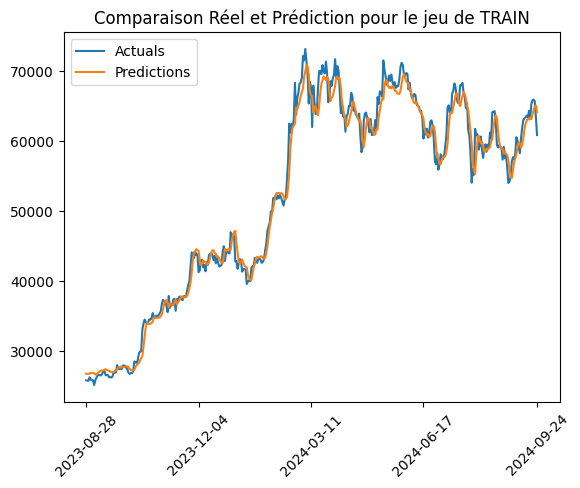

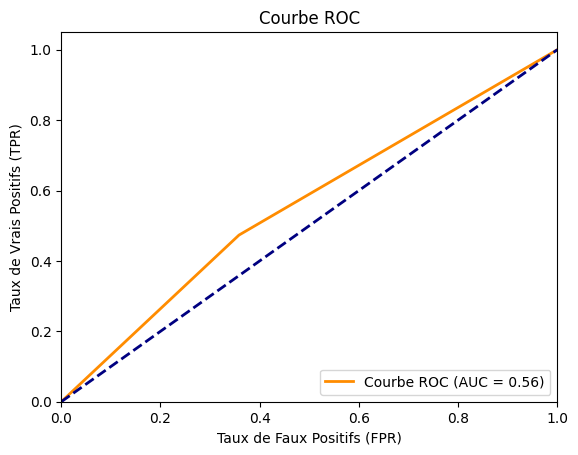

2/2 [==============================] - 0s 7ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-09-25  60825.742188  60649.281250     62660.847656                  0                     1
1  2024-09-26  60662.730469  60752.710938     61615.195312                  1                     1
2  2024-09-27  60770.464844  62086.000000     61200.851562                  1                     1
3  2024-09-28  62159.273438  62058.000000     61425.828125                  0                     0
4  2024-09-29  62130.113281  62819.910156     61769.914062                  1                     0
5  2024-09-30  62923.750000  62224.000000     62253.000000                  0                     0
6  2024-10-01  62303.027344  62160.488281     62398.902344                  0                     1
--Regression Metrics--
R^2 = 94.24551129341125%
MAE = 1688.994873046875
MSE = 5409172.0
RMSE = 2325.762670609364
MAPE = 2.309511415660

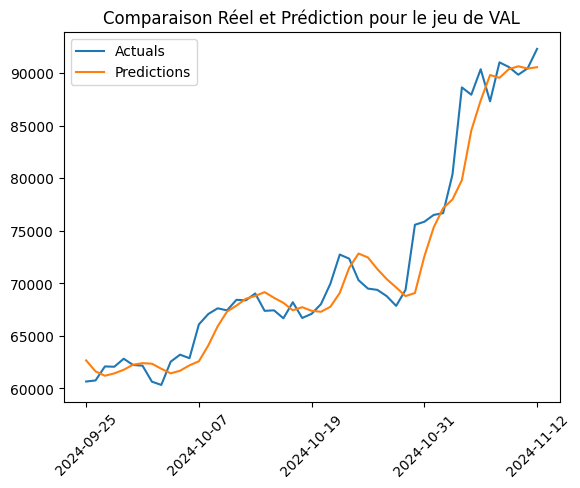

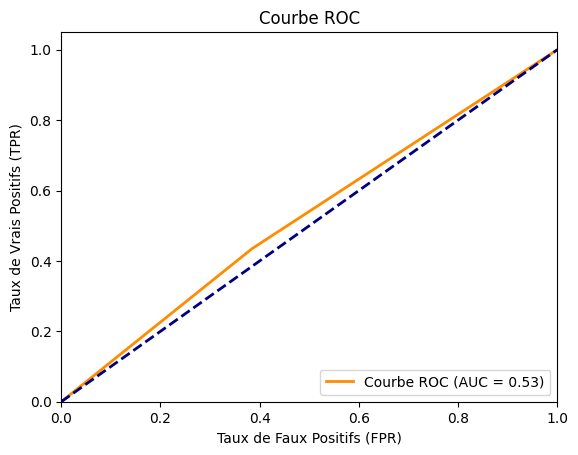

2/2 [==============================] - 0s 7ms/step
#####TEST#####
          Date     Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-11-13   95720.609375  94286.562500     94837.109375                  0                     0
1  2024-11-14   97209.007812  98317.117188     96194.671875                  1                     0
2  2024-11-15  100245.312500  98892.000000     98438.046875                  0                     0
3  2024-11-16  100678.382812  97672.398438    100118.898438                  0                     0
4  2024-11-17   99759.625000  97900.039062    100512.218750                  0                     1
5  2024-11-18   99931.117188  93010.007812    100479.992188                  0                     1
6  2024-11-19   96247.351562  91965.156250     98648.476562                  0                     1
--Regression Metrics--
R^2 = -9.475195407867432%
MAE = 2561.893798828125
MSE = 10533163.0
RMSE = 3245.48347708011
MAPE = 2.65

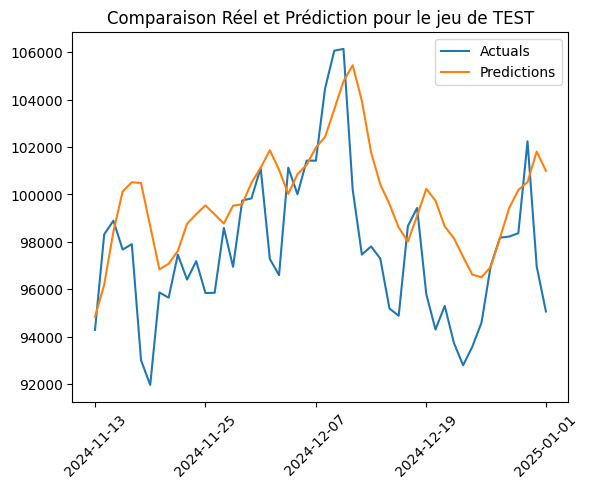

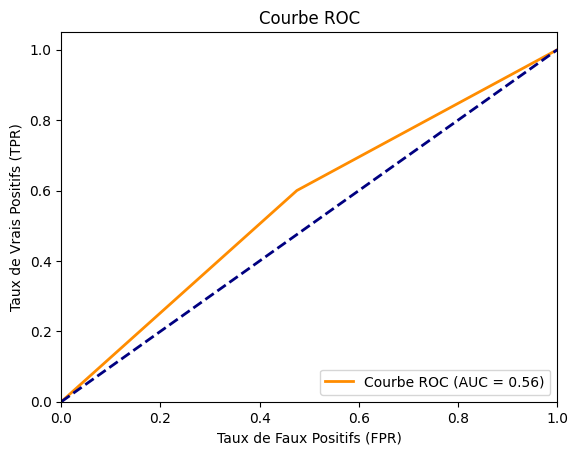

In [8]:
main_analyze_model_close_price(full_model_name, WINDOW_SIZE)

### Modèle 2: Close_price sur les données du 2017-08-17 au 2025-01-08

In [9]:
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2017_08_17_2025_01_08"    

datasets = main_pre_processing_close_price(data_name, WINDOW_SIZE)

model_name = f"Model2_Close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

X_train = datasets['TRAIN'][0][1]
y_train = datasets['TRAIN'][0][2]

X_val = datasets['VAL'][0][1]
y_val = datasets['VAL'][0][2]

main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1087

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 8s 88ms/step - loss: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 2/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0585

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 80ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 3/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0540

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0029 - root_mean_squared_error: 0.0541 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0512

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 5/100
68/68 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 6/100
68/68 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0456

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 7/100
68/68 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0448

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 8/100
68/68 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0444

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 81ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 9/100
68/68 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0423

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 80ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 10/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 11/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 12/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 13/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 14/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 0.0011 - val_root_me

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 18/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 19/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0400

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 82ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 20/100
68/68 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0384

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 72ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 21/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 22/100
68/68 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0380

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 82ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 9.5655e-04 - val_root_mean_squared_error: 0.0309
Epoch 23/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 24/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 9.6356e-04 - val_root_mean_squared_error: 0.0310
Epoch 25/100
68/68 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0374

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 81ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 26/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 27/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0371

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 9.5132e-04 - val_root_mean_squared_error: 0.0308
Epoch 28/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 9.2364e-04 - val_root_mean_squared_error: 0.0304
Epoch 29/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 9.6220e-04 - val_root_mean_squared_error: 0.0310
Epoch 30/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 9.9604e-04 - val_root_mean_squared_error: 0.0316
Epoch 31/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 32/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0361

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 9.2788e-04 - val_root_mean_squared_error: 0.0305
Epoch 33/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 9.5501e-04 - val_root_mean_squared_error: 0.0309
Epoch 34/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 35/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0363

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 81ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 36/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 8.8956e-04 - val_root_mean_squared_error: 0.0298
Epoch 37/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 9.1992e-04 - val_root_mean_squared_error: 0.0303
Epoch 38/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0367 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 39/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 9.7713e-04 - val_root_mean_squared_error: 0.0313
Epoch 40/100
68/68 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0337

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 80ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 9.5150e-04 - val_root_mean_squared_error: 0.0308
Epoch 41/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 9.8004e-04 - val_root_mean_squared_error: 0.0313
Epoch 42/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 8.3610e-04 - val_root_mean_squared_error: 0.0289
Epoch 43/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.3535e-04 - val_root_mean_squared_error: 0.0306
Epoch 44/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 8.5770e-04 - val_root_mean_squared_error: 0.0293
Epoch 45/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0358 - val_loss: 

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 72ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 70/100
68/68 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0328

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 8.2061e-04 - val_root_mean_squared_error: 0.0286
Epoch 71/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 7.8235e-04 - val_root_mean_squared_error: 0.0280
Epoch 72/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 9.1830e-04 - val_root_mean_squared_error: 0.0303
Epoch 73/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 74/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 75/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0015 -

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model2_Close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 76ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 7.8419e-04 - val_root_mean_squared_error: 0.0280
Epoch 83/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 7.9208e-04 - val_root_mean_squared_error: 0.0281
Epoch 84/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 7.9400e-04 - val_root_mean_squared_error: 0.0282
Epoch 85/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 8.2853e-04 - val_root_mean_squared_error: 0.0288
Epoch 86/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 87/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 8.90

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
68/68 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-08-17  4114.009766  4316.009766      4419.860840                  1                     1
1  2017-08-18  4316.009766  4280.680176      4510.170898                  0                     1
2  2017-08-19  4280.680176  4337.439941      4566.543945                  1                     1
3  2017-08-20  4337.439941  4310.009766      4622.876465                  0                     1
4  2017-08-21  4310.009766  4386.689941      4648.521484                  1                     1
5  2017-08-22  4386.689941  4587.479980      4689.119629                  1                     1
6  2017-08-23  4587.479980  4555.140137      4790.011230                  0                     1
--Regression Metrics--
R^2 = 99.56466555595398

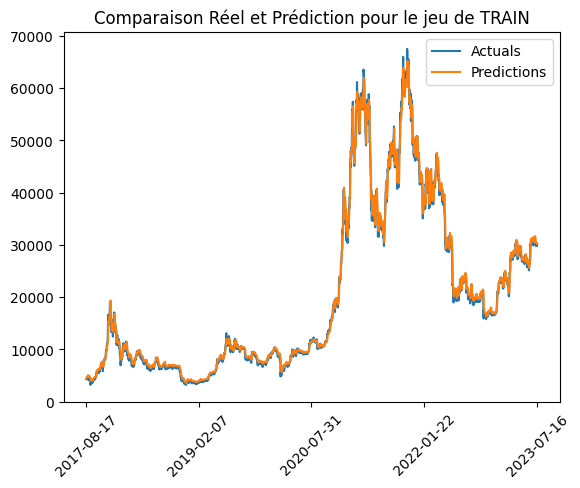

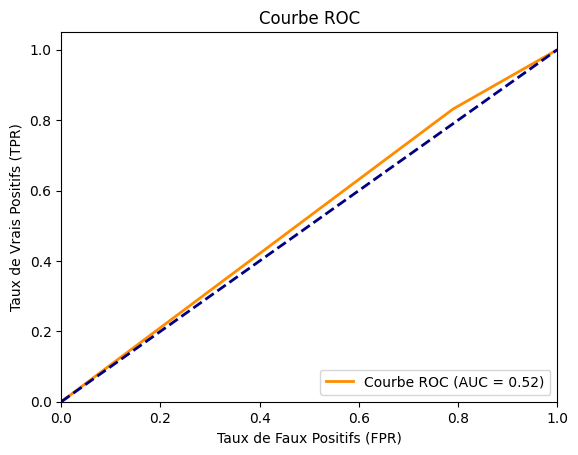

9/9 [==============================] - 0s 7ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-17  30083.750000  29176.500000     30081.271484                  0                     0
1  2023-07-18  29176.500000  29228.910156     29825.810547                  1                     1
2  2023-07-19  29228.910156  29351.960938     29653.980469                  1                     1
3  2023-07-20  29351.960938  29222.779297     29588.539062                  0                     1
4  2023-07-21  29222.779297  29314.140625     29513.285156                  1                     1
5  2023-07-22  29314.140625  29352.900391     29500.777344                  1                     1
6  2023-07-23  29352.900391  29281.089844     29514.564453                  0                     1
--Regression Metrics--
R^2 = 99.12652373313904%
MAE = 881.1315307617188
MSE = 1799996.875
RMSE = 1341.63962188063
MAPE = 1.99295133352

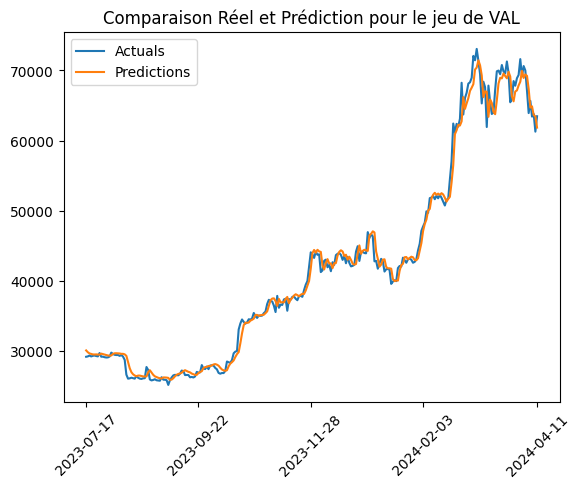

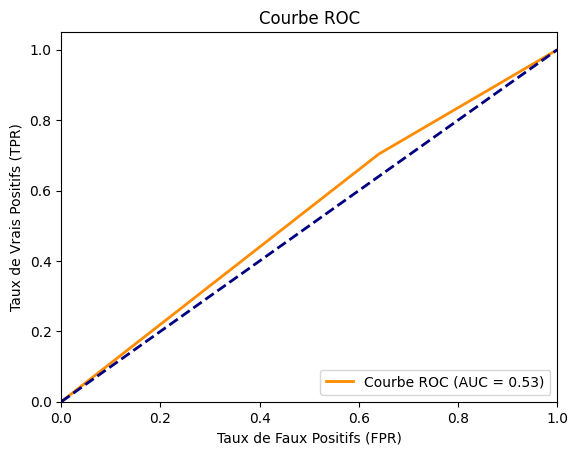

9/9 [==============================] - 0s 6ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-12  63470.082031  63818.007812     62871.902344                  1                     0
1  2024-04-13  63818.007812  64940.589844     63323.273438                  1                     0
2  2024-04-14  64940.589844  64941.148438     64262.925781                  1                     0
3  2024-04-15  64941.148438  66819.320312     64779.484375                  1                     0
4  2024-04-16  66819.320312  66414.000000     66171.156250                  0                     0
5  2024-04-17  66414.000000  64289.589844     66635.757812                  0                     1
6  2024-04-18  64289.589844  64498.339844     65516.582031                  1                     1
--Regression Metrics--
R^2 = 98.00628423690796%
MAE = 1564.5537109375
MSE = 4189035.25
RMSE = 2046.7132798709251
MAPE = 2.21870541572

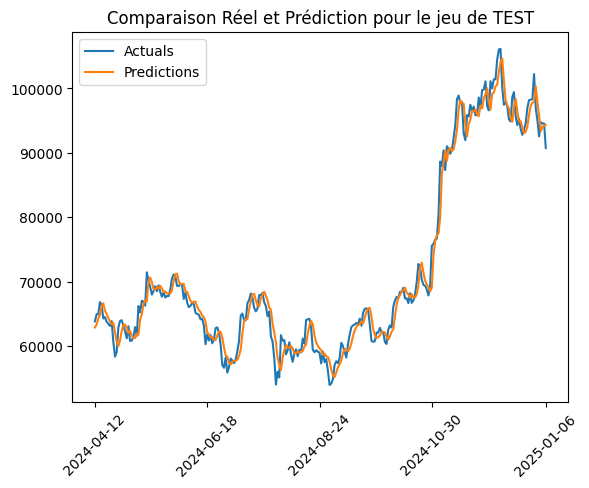

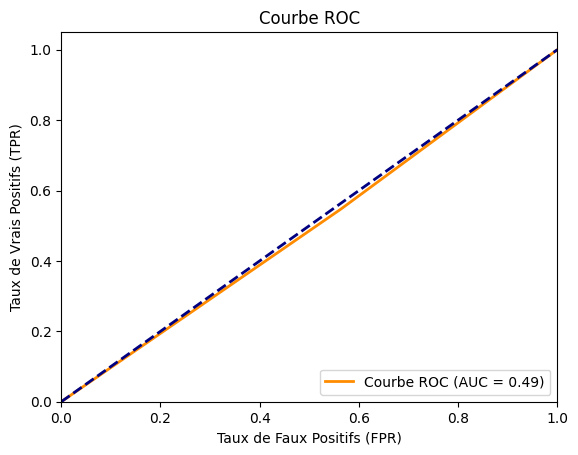

In [10]:
main_analyze_model_close_price(full_model_name, WINDOW_SIZE)

### Modèle 3: Log_close_price sur les données du 2017-08-17 au 2025-01-08

In [11]:
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_raw_1d_2017_08_17_2025_01_08"    

datasets = main_pre_processing_log_close_price(data_name, WINDOW_SIZE)

model_name = f"Model3_Log_close_price_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

X_train = datasets['TRAIN'][0][1]
y_train = datasets['TRAIN'][0][2]

X_val = datasets['VAL'][0][1]
y_val = datasets['VAL'][0][2]

main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
Epoch 1/100
66/68 [============================>.] - ETA: 0s - loss: 0.0251 - root_mean_squared_error: 0.1585

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 8s 88ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.0067 - root_mean_squared_error: 0.0816

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0757

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 85ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 4/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0702

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 81ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 5/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0044 - root_mean_squared_error: 0.0662

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 77ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/100
66/68 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0636

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 87ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 7/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0631

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 72ms/step - loss: 0.0040 - root_mean_squared_error: 0.0631 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 8/100
68/68 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 9/100
68/68 [==============================] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0612

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0037 - root_mean_squared_error: 0.0612 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 10/100
68/68 [==============================] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0602

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 11/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0563

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0032 - root_mean_squared_error: 0.0562 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 12/100
67/68 [============================>.] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0535

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 13/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 14/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 15/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 16/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0030 - root_mean_squared_error: 0.0549 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 17/100
67/68 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0530

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 18/100
68/68 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0519

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 82ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 9.7793e-04 - val_root_mean_squared_error: 0.0313
Epoch 19/100
68/68 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0506

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 20/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 21/100
68/68 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0498

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 22/100
67/68 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0492

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 23/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 24/100
68/68 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0485

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 25/100
68/68 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0471

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 26/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 27/100
68/68 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0465

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 76ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 28/100
68/68 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0462

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 82ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 29/100
66/68 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0451

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 30/100
67/68 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0455

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 31/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0448

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 32/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 33/100
67/68 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 83ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 9.2357e-04 - val_root_mean_squared_error: 0.0304
Epoch 34/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 35/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 8.8307e-04 - val_root_mean_squared_error: 0.0297
Epoch 36/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 9.2419e-04 - val_root_mean_squared_error: 0.0304
Epoch 37/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0419

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 81ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 38/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 39/100
68/68 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 80ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 40/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 9.3107e-04 - val_root_mean_squared_error: 0.0305
Epoch 41/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 42/100
68/68 [==============================] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0406

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 43/100
67/68 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0391

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 82ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 44/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 9.5179e-04 - val_root_mean_squared_error: 0.0309
Epoch 45/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 46/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 47/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 48/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0011 - val_roo

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 8.3924e-04 - val_root_mean_squared_error: 0.0290
Epoch 51/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 52/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 8.3574e-04 - val_root_mean_squared_error: 0.0289
Epoch 53/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0405 - val_loss: 9.8606e-04 - val_root_mean_squared_error: 0.0314
Epoch 54/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 9.1372e-04 - val_root_mean_squared_error: 0.0302
Epoch 55/100
68/68 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0382

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 82ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 56/100
67/68 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0379

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 9.5544e-04 - val_root_mean_squared_error: 0.0309
Epoch 57/100
68/68 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0374

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 85ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 9.5726e-04 - val_root_mean_squared_error: 0.0309
Epoch 58/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 59/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0373

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 8.3720e-04 - val_root_mean_squared_error: 0.0289
Epoch 60/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 61/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 9.9853e-04 - val_root_mean_squared_error: 0.0316
Epoch 62/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 63/100
68/68 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0366

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 9.9758e-04 - val_root_mean_squared_error: 0.0316
Epoch 64/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 7.6058e-04 - val_root_mean_squared_error: 0.0276
Epoch 65/100
66/68 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0355

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 8.3351e-04 - val_root_mean_squared_error: 0.0289
Epoch 66/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 67/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 68/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 69/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 70/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0020 - val_roo

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 8.7117e-04 - val_root_mean_squared_error: 0.0295
Epoch 77/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 78/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 79/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 7.7662e-04 - val_root_mean_squared_error: 0.0279
Epoch 80/100
68/68 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0357

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 7.7979e-04 - val_root_mean_squared_error: 0.0279
Epoch 81/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 82/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 7.3580e-04 - val_root_mean_squared_error: 0.0271
Epoch 83/100
65/68 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0357

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 74ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 6.9639e-04 - val_root_mean_squared_error: 0.0264
Epoch 84/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 7.6091e-04 - val_root_mean_squared_error: 0.0276
Epoch 85/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 7.6069e-04 - val_root_mean_squared_error: 0.0276
Epoch 86/100
68/68 [==============================] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0353

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 6s 84ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 7.4753e-04 - val_root_mean_squared_error: 0.0273
Epoch 87/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 9.1649e-04 - val_root_mean_squared_error: 0.0303
Epoch 88/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 89/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 8.8648e-04 - val_root_mean_squared_error: 0.0298
Epoch 90/100
68/68 [==============================] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0348

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model3_Log_close_price_jaquart_dense64_WS7-dataset_raw_1d_2017_08_17_2025_01_08-100/assets


68/68 [==============================] - 5s 73ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 8.5317e-04 - val_root_mean_squared_error: 0.0292
Epoch 91/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 9.4964e-04 - val_root_mean_squared_error: 0.0308
Epoch 92/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 8.5760e-04 - val_root_mean_squared_error: 0.0293
Epoch 93/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 94/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 7.1925e-04 - val_root_mean_squared_error: 0.0268
Epoch 95/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 9.17

X.shape (2700, 7, 1)
y.shape (2700, 1)
X_train_norm.shape (2160, 7, 1)
y_train_norm.shape (2160, 1)
68/68 [==============================] - 1s 6ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-08-17  4114.008301  4316.009766      3898.178711                  1                     0
1  2017-08-18  4316.009766  4280.679199      4018.665039                  0                     0
2  2017-08-19  4280.679199  4337.441895      4079.389404                  1                     0
3  2017-08-20  4337.441895  4310.008789      4139.854492                  0                     0
4  2017-08-21  4310.008789  4386.691406      4156.580078                  1                     0
5  2017-08-22  4386.691406  4587.481934      4194.117676                  1                     0
6  2017-08-23  4587.481934  4555.138672      4307.900879                  0                     0
--Regression Metrics--
R^2 = 99.52360987663269

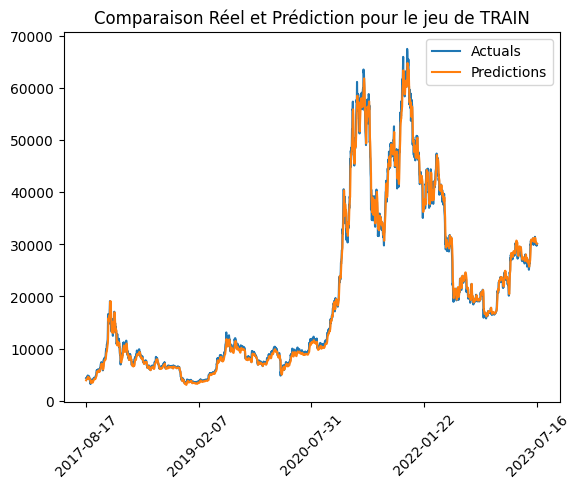

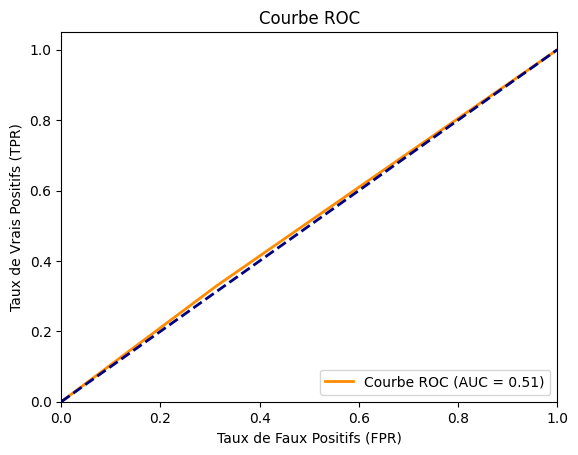

9/9 [==============================] - 0s 6ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-17  30083.763672  29176.484375     29644.314453                  0                     0
1  2023-07-18  29176.484375  29228.898438     29291.041016                  1                     1
2  2023-07-19  29228.898438  29351.947266     29078.761719                  1                     0
3  2023-07-20  29351.947266  29222.769531     29018.369141                  0                     0
4  2023-07-21  29222.769531  29314.152344     28939.246094                  1                     0
5  2023-07-22  29314.152344  29352.898438     28951.033203                  1                     0
6  2023-07-23  29352.898438  29281.099609     28989.462891                  0                     0
--Regression Metrics--
R^2 = 98.9808440208435%
MAE = 1001.1992797851562
MSE = 2100209.75
RMSE = 1449.2100434374584
MAPE = 2.3202707991

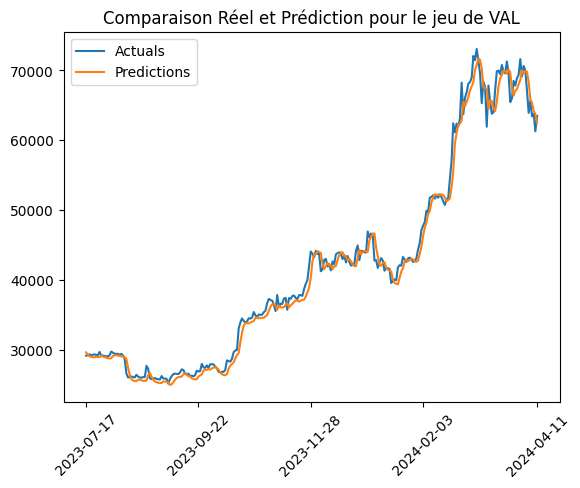

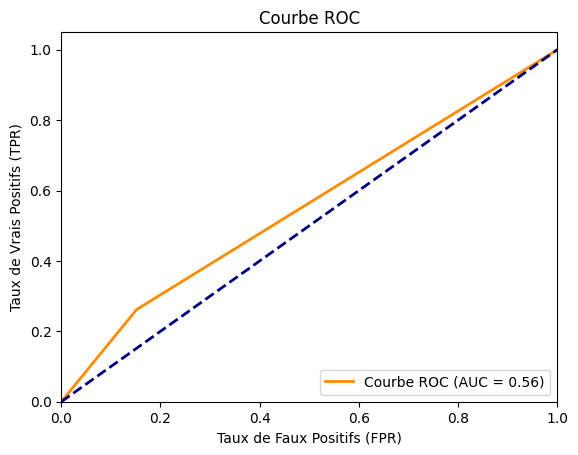

9/9 [==============================] - 0s 6ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-12  63470.078125  63817.984375     62465.632812                  1                     0
1  2024-04-13  63817.984375  64940.531250     62886.667969                  1                     0
2  2024-04-14  64940.531250  64941.152344     63671.781250                  1                     0
3  2024-04-15  64941.152344  66819.343750     64212.609375                  1                     0
4  2024-04-16  66819.343750  66414.015625     65306.531250                  0                     0
5  2024-04-17  66414.015625  64289.574219     65782.968750                  0                     0
6  2024-04-18  64289.574219  64498.371094     64996.792969                  1                     1
--Regression Metrics--
R^2 = 97.73433208465576%
MAE = 1654.44140625
MSE = 4760436.0
RMSE = 2181.8423407753367
MAPE = 2.31979452073574

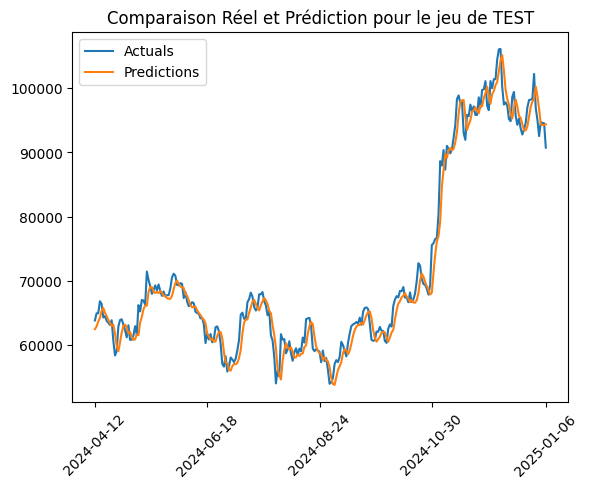

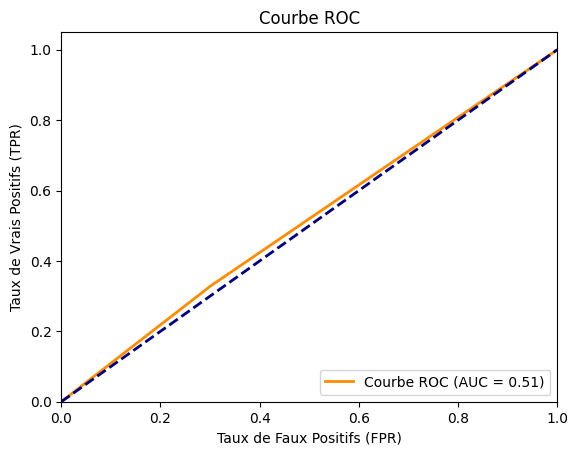

In [12]:
main_analyze_model_log_close_price(full_model_name, WINDOW_SIZE)

### Modèle 4:  dataset_v2 avec log_close_price sur les données du 2017-08-17 au 2025-01-08

In [13]:
"""
preprocess2 les données data_name et entraine un modele model_name
"""
WINDOW_SIZE = 7
N_EPOCHS = 100
data_name = "dataset_v2_1d_2017_08_17_2025_01_08"    

datasets = main_pre_processing_multivar(data_name, WINDOW_SIZE)

model_name = f"Model4_multi_var_jaquart_dense64_WS{WINDOW_SIZE}"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

X_train = datasets['TRAIN'][0][1]
y_train = datasets['TRAIN'][0][2]

X_val = datasets['VAL'][0][1]
y_val = datasets['VAL'][0][2]

main_training_model(full_model_name, X_train, y_train, X_val, y_val, WINDOW_SIZE, N_EPOCHS)

Index(['log_close_price', 'Open_price', 'High_price', 'Low_price', 'Volume',
       'Quote_volume', 'Nb_trades', 'Taker_buy_base_volume',
       'Taker_buy_quote_volume', 'evolution_prct', 'lundi', 'mardi',
       'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche', 'janvier',
       'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout',
       'septembre', 'octobre', 'novembre', 'decembre', 'RSI', 'EMA_14', 'MACD',
       'MACD_Signal'],
      dtype='object')
X.shape (2667, 7, 33)
y.shape (2667,)
X_train_norm.shape (2133, 7, 33)
y_train_norm.shape (2133, 1)
Epoch 1/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0250 - root_mean_squared_error: 0.1580

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 8s 95ms/step - loss: 0.0244 - root_mean_squared_error: 0.1560 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1035

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 78ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 3/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0084 - root_mean_squared_error: 0.0919

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 4/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0846

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 74ms/step - loss: 0.0071 - root_mean_squared_error: 0.0843 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 5/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0757

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 6/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0054 - root_mean_squared_error: 0.0734

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 74ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 7/100
67/67 [==============================] - ETA: 0s - loss: 0.0053 - root_mean_squared_error: 0.0726

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0844
Epoch 8/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0699

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 73ms/step - loss: 0.0049 - root_mean_squared_error: 0.0700 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 9/100
66/67 [============================>.] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0670

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0045 - root_mean_squared_error: 0.0671 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1085
Epoch 10/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 11/100
67/67 [==============================] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0641

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 12/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0624

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 86ms/step - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 13/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0612

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 74ms/step - loss: 0.0037 - root_mean_squared_error: 0.0611 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 14/100
66/67 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0568

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 15/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0557

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 76ms/step - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1023
Epoch 16/100
67/67 [==============================] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0553

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 17/100
65/67 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0548

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0105 - val_root_mean_squared_error: 0.1022
Epoch 18/100
66/67 [============================>.] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0543

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1076
Epoch 19/100
65/67 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0522

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 20/100
67/67 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0520

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 89ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1039
Epoch 21/100
67/67 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0509

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 76ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 22/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0489

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1041
Epoch 23/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 24/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 79ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 25/100
66/67 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0467

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 89ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 26/100
67/67 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0454

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 27/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 28/100
65/67 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0449

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 87ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 29/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0450

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1100
Epoch 30/100
67/67 [==============================] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0447

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 86ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1028
Epoch 31/100
67/67 [==============================] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1056
Epoch 32/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0857
Epoch 33/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 34/100
66/67 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0414

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 74ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 35/100
65/67 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0407

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1125
Epoch 36/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0418 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 37/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 38/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 39/100
65/67 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0408

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 77ms/step - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0986
Epoch 40/100
66/67 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0395

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 87ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 41/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 42/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1068
Epoch 43/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0975
Epoch 44/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1014
Epoch 45/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0378

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 76ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 46/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 47/100
66/67 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0368

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0014 - root_mean_squared_error: 0.0367 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 48/100
67/67 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0366

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 49/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 50/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0402 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 51/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 52/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 53/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0365

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 86ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0980
Epoch 54/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 55/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0951
Epoch 56/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 57/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0951
Epoch 58/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0087 - val_root_me

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 74ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1011
Epoch 62/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 63/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907
Epoch 64/100
65/67 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0353

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 88ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 65/100
64/67 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0346

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 66/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 67/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0366 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0960
Epoch 68/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0903
Epoch 69/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0952
Epoch 70/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0080 - val_root_me

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 91ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 79/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0912
Epoch 80/100
66/67 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0343

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 75ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0875
Epoch 81/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 82/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0993
Epoch 83/100
65/67 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0340

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 90ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 84/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888
Epoch 85/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1070
Epoch 86/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0344 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 87/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 88/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0090 - val_root_me

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 5s 77ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0892
Epoch 90/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0883
Epoch 91/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 92/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0935
Epoch 93/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0012 - root_mean_squared_error: 0.0339 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 94/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0111 - val_root_me

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/Model4_multi_var_jaquart_dense64_WS7-dataset_v2_1d_2017_08_17_2025_01_08-100/assets


67/67 [==============================] - 6s 85ms/step - loss: 0.0011 - root_mean_squared_error: 0.0326 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0891
Epoch 97/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0967
Epoch 98/100
67/67 [==============================] - 1s 18ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 99/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889
Epoch 100/100
67/67 [==============================] - 1s 17ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944


Index(['log_close_price', 'Open_price', 'High_price', 'Low_price', 'Volume',
       'Quote_volume', 'Nb_trades', 'Taker_buy_base_volume',
       'Taker_buy_quote_volume', 'evolution_prct', 'lundi', 'mardi',
       'mercredi', 'jeudi', 'vendredi', 'samedi', 'dimanche', 'janvier',
       'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout',
       'septembre', 'octobre', 'novembre', 'decembre', 'RSI', 'EMA_14', 'MACD',
       'MACD_Signal'],
      dtype='object')
X.shape (2667, 7, 33)
y.shape (2667,)
X_train_norm.shape (2133, 7, 33)
y_train_norm.shape (2133, 1)
67/67 [==============================] - 1s 7ms/step
#####TRAIN#####
          Date   Actual N+7   Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2017-09-19  3920.750244  3882.351807      4074.486084                  0                     1
1  2017-09-20  3882.351807  4193.001953      4080.405029                  1                     1
2  2017-09-21  4193.001953  4174.500977      4296.179688      

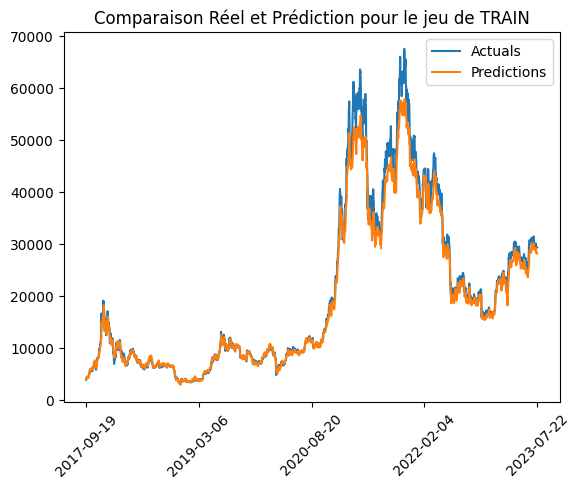

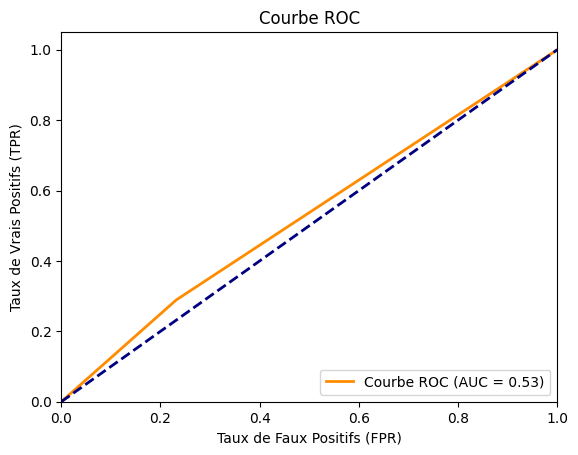

9/9 [==============================] - 0s 6ms/step
#####VAL#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2023-07-23  29352.898438  29281.099609     31206.363281                  0                     1
1  2023-07-24  29281.099609  29232.244141     31460.595703                  0                     1
2  2023-07-25  29232.244141  29705.980469     31487.310547                  1                     1
3  2023-07-26  29705.980469  29186.001953     32032.732422                  0                     1
4  2023-07-27  29186.001953  29193.628906     31594.423828                  1                     1
5  2023-07-28  29193.628906  29114.003906     31509.689453                  0                     1
6  2023-07-29  29114.003906  29072.134766     30926.152344                  0                     1
--Regression Metrics--
R^2 = 90.8465564250946%
MAE = 3615.254638671875
MSE = 19251698.0
RMSE = 4387.675694487914
MAPE = 8.381430804729

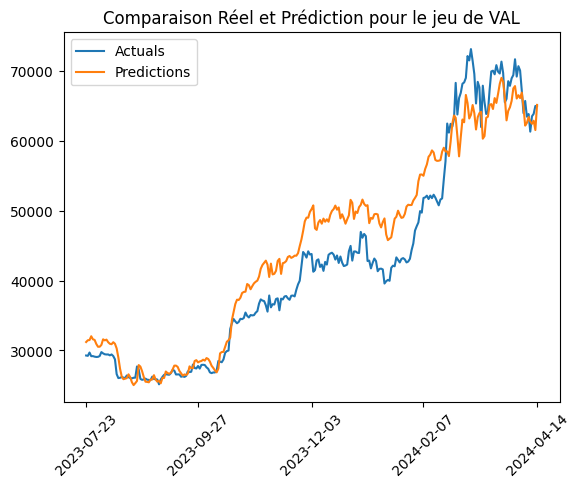

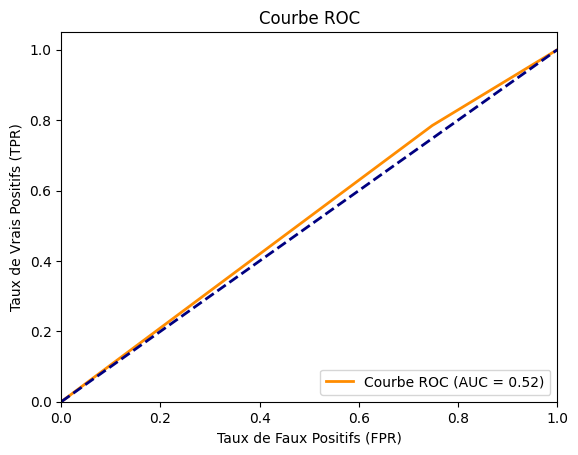

9/9 [==============================] - 0s 6ms/step
#####TEST#####
          Date    Actual N+7    Actual N+8  Predictions N+8  Actual UP or DOWN  Predicted UP or DOWN
0  2024-04-15  64941.152344  66819.343750     71250.687500                  1                     1
1  2024-04-16  66819.343750  66414.015625     74049.570312                  0                     1
2  2024-04-17  66414.015625  64289.574219     74189.109375                  0                     1
3  2024-04-18  64289.574219  64498.371094     72147.101562                  1                     1
4  2024-04-19  64498.371094  63769.984375     71680.062500                  0                     1
5  2024-04-20  63769.984375  63461.964844     70230.992188                  0                     1
6  2024-04-21  63461.964844  63118.648438     69496.695312                  0                     1
--Regression Metrics--
R^2 = 85.56135296821594%
MAE = 4822.32373046875
MSE = 30598374.0
RMSE = 5531.579702038108
MAPE = 7.20205754041

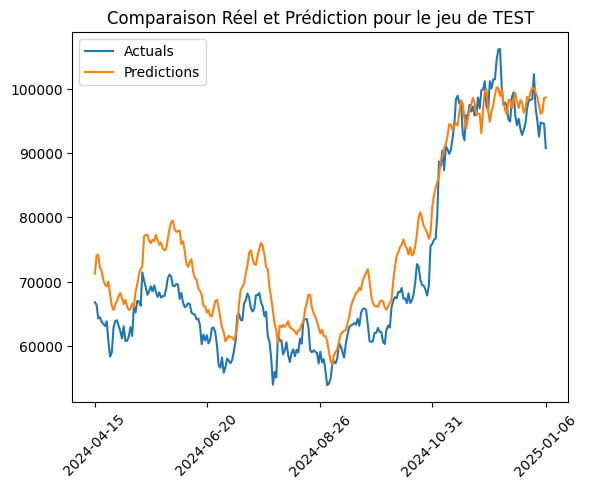

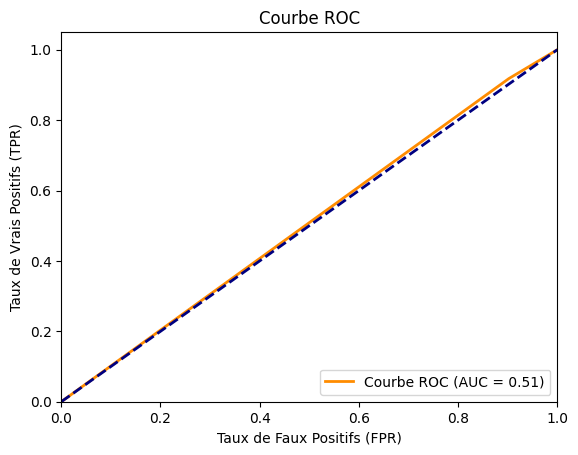

In [14]:
main_analyze_model_multivar(full_model_name, WINDOW_SIZE)